In [1]:
import geopandas as gpd
from shapely.geometry import Point
import numpy as np
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import pandas as pd
import rasterio
import matplotlib.pyplot as plt

In [2]:
crta_coords = pd.read_csv('calculate_aoo/df2csv/cornuta_all.csv')
crta_coords = crta_coords[(crta_coords['lat']>0) & (crta_coords['long']>-20)]
print(f'lat_min = {crta_coords['lat'].min()}\nlat_max = {crta_coords['lat'].max()}\nlon_min = {crta_coords['long'].min()}\nlat_max = {crta_coords['long'].max()}\n')

lat_min = 34.9625
lat_max = 59.918117
lon_min = -7.537369
lat_max = 51.08368



In [3]:
bbox = [-8, 35, 52, 60] #minx, miny, maxx, maxy

num_points_side = int(np.sqrt(5000))  
lons = np.linspace(bbox[0], bbox[2], num_points_side)
lats = np.linspace(bbox[1], bbox[3], num_points_side)

grid_points = [Point(lon, lat) for lat in lats for lon in lons]
grid_gdf = gpd.GeoDataFrame(geometry=grid_points)

shapefile_path = 'data/shapefiles/ne_110m_land/ne_110m_land.shp'
gdf = gpd.read_file(shapefile_path)

lakes_shapefile_path = 'data/shapefiles/ne_110m_lakes/ne_110m_lakes.shp'
lakes_gdf = gpd.read_file(lakes_shapefile_path)

land_points = grid_gdf[grid_gdf['geometry'].apply(lambda point:gdf.contains(point).any() and not lakes_gdf.contains(point).any())]
land_coordinates = [(point.y, point.x) for point in land_points['geometry']]

lakes = cfeature.NaturalEarthFeature(category='physical', name='lakes', scale='110m')

(-10.99999999999996, 52.9999999999998, 33.99999999999987, 69.03428709808546)

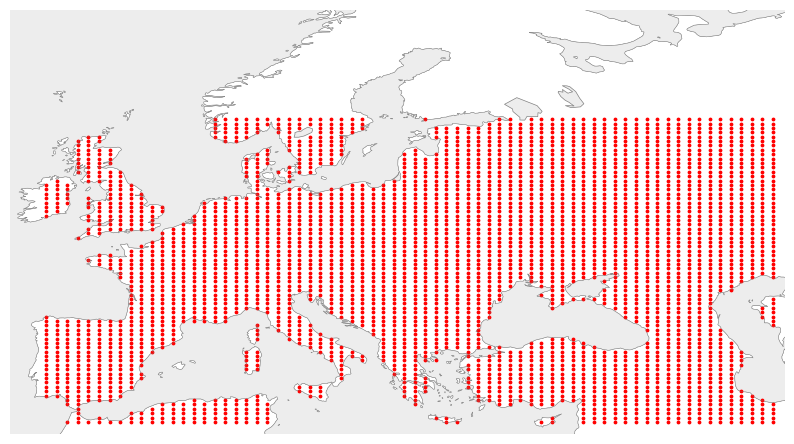

In [4]:

plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})
ax = plt.gca()
ax.set_extent([-11, 53, 34,  66])  # Set the extent (longitude, longitude, latitude, latitude)


ax.add_feature(cfeature.LAND, facecolor='white', edgecolor='gray', linewidth=.5)
ax.add_feature(cfeature.COASTLINE, linewidth=.2, edgecolor='gray')
ax.add_feature(cfeature.OCEAN, facecolor='#ededed', linewidth=.1, zorder=1, edgecolor='gray')
ax.add_feature(lakes, facecolor='#ededed', linewidth=.5, edgecolor='gray')

#ndvi_tiff_path = '/home/mpgetz/repos/bee_mapping/data/wc2.1_30s_bio/NDVI_hires.tif'
#with rasterio.open(ndvi_tiff_path) as ndvi_src:
#   ndvi_data = ndvi_src.read(1)
#    vmin, vmax = ndvi_data.min(), ndvi_data.max()

#    plt.imshow(ndvi_data, vmin=-1, vmax=1, origin='upper', transform=ccrs.PlateCarree(), cmap='twilight_shifted')

lats, lons = zip(*land_coordinates)
ax.scatter(lons, lats, transform=ccrs.PlateCarree(), marker='o', color='red', s=3)
ax.axis('off')

# cbar = plt.colorbar(label='NDVI', fraction=0.03, pad=0.04)
# cbar.set_label('NDVI') , extent=[-127, -64.5, 34, 55]

In [5]:
europe_df = pd.DataFrame(land_coordinates, columns=['lat', 'lon'])

In [6]:
import os
from concurrent.futures import ThreadPoolExecutor


def get_value_from_array(lat, long, src, array):
    try:
        row, col = src.index(long, lat)
        return array[row, col]
    except Exception as e:
        print(f'Error at {lat}, {long}: {e}')
        return None
    
ndvi_tiff_path = 'data/tifs/NDVI_Image.tif'
all_files = [ndvi_tiff_path]

print(all_files)

def process_file(file):
    column_name = 'ndvi'
    print(f'Processing: {column_name}\n')

    with rasterio.open(file) as src:
        array = src.read(1)  
        europe_df[column_name] = europe_df.apply(lambda row: get_value_from_array(row['lat'], row['lon'], src, array), axis=1)

with ThreadPoolExecutor(max_workers=1) as executor: 
    executor.map(process_file, all_files)

directory = 'data/wc2.1_30s_bio'
all_files = [f for f in os.listdir(directory) if f.endswith('.tif') and "wc2.1_30s_" in f]

print(all_files)

def process_file(file):
    column_name = file.split("wc2.1_30s_")[1].replace(".tif", "")
    file_path = os.path.join(directory, file)
    print(f'Processing: {column_name}\n')

    with rasterio.open(file_path) as src:
        array = src.read(1)  
        europe_df[column_name] = europe_df.apply(lambda row: get_value_from_array(row['lat'], row['lon'], src, array), axis=1)

with ThreadPoolExecutor(max_workers=4) as executor:  
    executor.map(process_file, all_files)

# america_df.to_csv('america_bioclim_ndvi.csv')


['data/tifs/NDVI_Image.tif']
Processing: ndvi

['wc2.1_30s_bio_11.tif', 'wc2.1_30s_bio_3.tif', 'wc2.1_30s_bio_9.tif', 'wc2.1_30s_bio_13.tif', 'wc2.1_30s_bio_5.tif', 'wc2.1_30s_bio_6.tif', 'wc2.1_30s_elev.tif', 'wc2.1_30s_bio_17.tif', 'wc2.1_30s_bio_10.tif', 'wc2.1_30s_bio_2.tif', 'wc2.1_30s_bio_15.tif', 'wc2.1_30s_bio_12.tif', 'wc2.1_30s_bio_1.tif', 'wc2.1_30s_bio_16.tif', 'wc2.1_30s_bio_8.tif', 'wc2.1_30s_bio_4.tif', 'wc2.1_30s_bio_19.tif', 'wc2.1_30s_bio_7.tif', 'wc2.1_30s_bio_14.tif', 'wc2.1_30s_bio_18.tif']
Processing: bio_11

Processing: bio_3

Processing: bio_9

Processing: bio_13

Processing: bio_5

Processing: bio_6

Processing: elev

Processing: bio_17

Processing: bio_10

Processing: bio_2

Processing: bio_15

Processing: bio_12

Processing: bio_1

Processing: bio_16

Processing: bio_8

Processing: bio_4

Processing: bio_19

Processing: bio_7

Processing: bio_14

Processing: bio_18



In [8]:
europe = europe_df.copy()
europe_points = europe[['lat', 'lon']]
europe = europe.drop(columns=['lat', 'lon'])
europe['group'] = 'europe'

,ndvi,bio_13,bio_11,bio_9,bio_5,elev,bio_3,bio_6,bio_17,bio_12,...,bio_16,bio_15,bio_1,bio_8,bio_19,bio_14,bio_7,bio_18,bio_4,group
0,-0.125140,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-32768,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,europe
1,0.283199,1.490000e+02,1.096667e+01,2.548333e+01,3.360000e+01,328,3.984742e+01,5.200000e+00,1.100000e+01,8.290000e+02,...,4.140000e+02,8.102385e+01,1.797500e+01,1.096667e+01,4.140000e+02,0.000000e+00,2.840000e+01,1.100000e+01,5.869393e+02,europe
2,0.163205,1.260000e+02,5.750000e+00,2.031667e+01,2.950000e+01,1343,4.083620e+01,4.000000e-01,2.400000e+01,8.320000e+02,...,3.630000e+02,7.010957e+01,1.264167e+01,6.750000e+00,3.500000e+02,2.000000e+00,2.910000e+01,2.400000e+01,5.944051e+02,europe
3,0.131960,8.000000e+01,5.966667e+00,2.040000e+01,2.900000e+01,1270,3.946429e+01,1.000000e+00,3.100000e+01,5.330000e+02,...,2.100000e+02,5.642151e+01,1.277500e+01,5.966667e+00,2.100000e+02,5.000000e+00,2.800000e+01,3.700000e+01,5.924545e+02,europe
4,0.130316,5.800000e+01,1.168333e+01,2.335000e+01,3.080000e+01,323,4.323129e+01,6.300000e+00,7.000000e+00,3.100000e+02,...,1.290000e+02,7.305995e+01,1.734583e+01,1.221667e+01,1.250000e+02,0.000000e+00,2.450000e+01,1.400000e+01,4.868333e+02,europe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3411,0.303576,8.100000e+01,-1.166667e+01,-4.116667e+00,2.200000e+01,183,2.137961e+01,-1.690000e+01,8.800000e+01,6.300000e+02,...,2.250000e+02,3.443332e+01,1.808333e+00,1.505000e+01,1.110000e+02,2.600000e+01,3.890000e+01,2.250000e+02,1.075533e+03,europe
3412,0.321320,7.900000e+01,-1.166667e+01,-4.116667e+00,2.240000e+01,184,2.088717e+01,-1.630000e+01,8.300000e+01,6.020000e+02,...,2.150000e+02,3.583277e+01,1.958333e+00,1.535000e+01,1.030000e+02,2.500000e+01,3.870000e+01,2.150000e+02,1.087950e+03,europe
3413,0.268472,8.000000e+01,-1.241667e+01,-4.866667e+00,2.260000e+01,184,2.160417e+01,-1.740000e+01,8.700000e+01,5.940000e+02,...,2.170000e+02,3.527664e+01,1.545833e+00,1.528333e+01,1.010000e+02,2.600000e+01,4.000000e+01,2.170000e+02,1.114048e+03,europe
3414,0.265417,8.100000e+01,-1.278333e+01,-5.116667e+00,2.280000e+01,164,2.250200e+01,-1.890000e+01,8.100000e+01,5.960000e+02,...,2.180000e+02,3.641564e+01,1.300000e+00,1.523333e+01,1.050000e+02,2.500000e+01,4.170000e+01,2.180000e+02,1.129461e+03,europe


In [96]:
europe = europe[europe['elev'] > 0]


In [97]:
europe

,ndvi,bio_13,bio_11,bio_9,bio_5,elev,bio_3,bio_6,bio_17,bio_12,...,bio_16,bio_15,bio_1,bio_8,bio_19,bio_14,bio_7,bio_18,bio_4,group
1,0.283199,149.0,10.966667,25.483334,33.599998,328,39.847420,5.200000,11.0,829.0,...,414.0,81.023849,17.975000,10.966667,414.0,0.0,28.399998,11.0,586.939270,europe
2,0.163205,126.0,5.750000,20.316666,29.500000,1343,40.836197,0.400000,24.0,832.0,...,363.0,70.109566,12.641666,6.750000,350.0,2.0,29.100000,24.0,594.405090,europe
3,0.131960,80.0,5.966667,20.400000,29.000000,1270,39.464287,1.000000,31.0,533.0,...,210.0,56.421509,12.775000,5.966667,210.0,5.0,28.000000,37.0,592.454468,europe
4,0.130316,58.0,11.683333,23.350000,30.799999,323,43.231293,6.300000,7.0,310.0,...,129.0,73.059952,17.345833,12.216667,125.0,0.0,24.500000,14.0,486.833252,europe
5,0.120632,48.0,11.366667,24.850000,33.799999,314,44.913795,4.800000,16.0,378.0,...,141.0,54.751629,17.679167,13.400000,139.0,2.0,29.000000,27.0,562.791138,europe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3411,0.303576,81.0,-11.666667,-4.116667,22.000000,183,21.379606,-16.900000,88.0,630.0,...,225.0,34.433319,1.808333,15.049999,111.0,26.0,38.900002,225.0,1075.533325,europe
3412,0.321320,79.0,-11.666667,-4.116667,22.400000,184,20.887167,-16.299999,83.0,602.0,...,215.0,35.832771,1.958333,15.350000,103.0,25.0,38.699997,215.0,1087.950195,europe
3413,0.268472,80.0,-12.416666,-4.866667,22.600000,184,21.604166,-17.400000,87.0,594.0,...,217.0,35.276638,1.545833,15.283334,101.0,26.0,40.000000,217.0,1114.047607,europe
3414,0.265417,81.0,-12.783333,-5.116667,22.799999,164,22.501999,-18.900000,81.0,596.0,...,218.0,36.415638,1.300000,15.233334,105.0,25.0,41.699997,218.0,1129.460815,europe


In [98]:
america = pd.read_csv('data/csv/10k_america_bioclim_ndvi.csv', index_col=None)
america = america.drop(columns=['Unnamed: 0'])
america = america[america['bio_13']!= -3.4e+38]
america = america[america['elev']> 0]
column_order = europe_df.columns.tolist()
america = america[column_order]
america_points = america[['lat', 'lon']]
america = america.drop(columns=['lat', 'lon'])
america['group'] = 'america'


In [99]:
america

,ndvi,bio_13,bio_11,bio_9,bio_5,elev,bio_3,bio_6,bio_17,bio_12,...,bio_16,bio_15,bio_1,bio_8,bio_19,bio_14,bio_7,bio_18,bio_4,group
0,0.135494,33.0,17.050000,21.633333,36.7,39,61.215750,7.5,1.0,136.0,...,76.0,93.943000,21.995832,28.133333,41.0,0.0,29.200000,76.0,445.64795,america
1,0.144761,77.0,17.033333,23.733334,37.8,390,59.406780,8.3,1.0,255.0,...,180.0,122.397385,22.712500,28.916666,45.0,0.0,29.500000,180.0,484.37927,america
2,0.299956,188.0,19.433334,23.283333,36.7,36,59.825870,9.9,7.0,650.0,...,477.0,120.599450,24.941666,29.866667,55.0,2.0,26.800001,349.0,447.65973,america
3,0.388679,251.0,19.783333,24.316668,36.7,360,59.923664,10.5,16.0,928.0,...,640.0,111.806800,24.525000,27.966667,91.0,4.0,26.200000,554.0,367.71100,america
4,0.406841,298.0,11.016666,14.716667,25.2,2233,63.143940,3.2,56.0,1283.0,...,774.0,91.926125,14.679167,17.200000,194.0,11.0,22.000000,699.0,277.82810,america
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6600,0.192897,104.0,-21.450000,-19.916666,17.6,505,21.848290,-29.2,137.0,804.0,...,291.0,31.745638,-4.612500,9.766666,144.0,39.0,46.800003,269.0,1295.78710,america
6601,-0.086839,105.0,-20.833334,-20.833334,16.6,466,20.916483,-28.5,149.0,809.0,...,284.0,28.685783,-4.508333,10.166667,149.0,43.0,45.100000,284.0,1255.31750,america
6602,0.155556,110.0,-20.950000,-19.500000,17.9,500,22.419355,-28.6,160.0,864.0,...,303.0,28.639341,-4.412500,9.866667,162.0,47.0,46.500000,284.0,1279.04460,america
6603,-0.082520,107.0,-20.066666,-20.066666,15.3,466,21.581196,-27.6,173.0,878.0,...,290.0,23.458233,-4.462500,9.533334,173.0,52.0,42.900000,290.0,1193.07500,america


In [100]:
osmia = pd.read_csv('data/csv/bioclim.csv')
osmia = osmia.drop(columns=['Unnamed: 0'])
osmia = osmia[column_order]
osmia = osmia[osmia['bio_13']!=-3.4e+38]
osmia = osmia[osmia['elev']> 0]
coords = osmia[['lat', 'lon']]
# osmia = osmia.drop(columns=['lat', 'lon'])
# osmia['group'] = 'osmia'


crta_coords_filtered = pd.read_csv('data/csv/crta_coords_filtered.csv')
crta_coords_filtered.columns = ['lat', 'lon']
osmia = pd.merge(osmia, crta_coords_filtered, on=['lat', 'lon'])
osmia = osmia.drop_duplicates(subset=['lat', 'lon'])
osmia = osmia[osmia['bio_13']!=-3.4e+38]
osmia_coords = osmia[['lat', 'lon']]
osmia = osmia.drop(columns=['lat', 'lon'])
osmia['group'] = 'osmia'
osmia

,ndvi,bio_13,bio_11,bio_9,bio_5,elev,bio_3,bio_6,bio_17,bio_12,...,bio_16,bio_15,bio_1,bio_8,bio_19,bio_14,bio_7,bio_18,bio_4,group
0,0.157664,82.0,1.100000,2.116667,24.6,199,29.925650,-2.3,125.0,663.0,...,230.0,25.539827,9.683333,18.533333,132.0,36.0,26.900000,230.0,710.95750,osmia
10,0.151344,81.0,1.400000,2.483333,24.9,117,30.308643,-2.1,120.0,645.0,...,227.0,27.204247,10.008333,18.816666,125.0,35.0,27.000000,227.0,709.33014,osmia
45,0.178543,71.0,1.800000,4.933333,23.0,79,31.550068,-1.3,129.0,616.0,...,189.0,17.194235,9.391666,17.350000,136.0,35.0,24.300000,189.0,634.90454,osmia
46,0.213319,79.0,1.416667,2.500000,25.1,106,30.381304,-2.0,113.0,630.0,...,220.0,27.033867,10.066667,18.900000,121.0,33.0,27.100000,220.0,711.54870,osmia
54,0.289286,74.0,2.416667,5.600000,23.5,114,33.741497,-1.0,147.0,696.0,...,204.0,13.882888,9.758333,16.016666,157.0,43.0,24.500000,200.0,611.29083,osmia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21163,0.241975,64.0,2.066667,3.233333,24.7,200,33.107235,-1.1,109.0,564.0,...,182.0,19.824036,10.029167,16.816668,117.0,35.0,25.800001,165.0,663.19977,osmia
21164,0.259833,67.0,2.250000,3.466667,25.2,97,33.460560,-1.0,117.0,600.0,...,196.0,20.291124,10.333333,17.200000,129.0,38.0,26.200000,175.0,669.74330,osmia
21165,0.220172,76.0,2.566667,3.800000,25.3,92,32.403847,-0.7,116.0,624.0,...,215.0,24.495295,10.687500,17.500000,123.0,37.0,26.000000,192.0,674.28120,osmia
21166,0.302638,64.0,1.983333,3.066667,23.7,157,30.981182,-1.1,125.0,606.0,...,184.0,16.734297,9.800000,16.333334,143.0,41.0,24.800001,165.0,648.14070,osmia


In [53]:
from sklearn.preprocessing import StandardScaler

In [113]:
combined = pd.concat([europe, america, osmia], ignore_index=True)
combined_points = pd.concat([europe_points, america_points, osmia_coords], ignore_index=True)
combined.describe()
combined_vars = combined.drop(columns=['group'])
scaler = StandardScaler()
df_scaled = scaler.fit_transform(combined_vars)
combined_scaled = pd.DataFrame(df_scaled, columns=combined_vars.columns)
bio_columns = [col for col in combined_scaled.columns if col.startswith('bio_')]


other_columns = [col for col in combined_scaled.columns if not col.startswith('bio_')]
bio_columns_sorted = sorted(bio_columns, key=lambda x: (x.split('_')[0], int(x.split('_')[1])))
other_columns_sorted = sorted(other_columns)
sorted_columns = bio_columns_sorted + other_columns_sorted
combined_scaled = combined_scaled[sorted_columns]
combined_scaled

,bio_1,bio_2,bio_3,bio_4,bio_5,bio_6,bio_7,bio_8,bio_9,bio_10,...,bio_12,bio_13,bio_14,bio_15,bio_16,bio_17,bio_18,bio_19,elev,ndvi
0,1.819330,0.281187,0.972555,-0.880171,1.650222,1.372230,-0.442007,-0.415578,2.064730,1.689847,...,0.289223,1.464546,-1.755297,2.472665,1.473382,-1.685051,-2.262989,2.261456,-0.238621,0.418176
1,0.731749,0.475505,1.119088,-0.849224,0.764335,0.790664,-0.358120,-1.047418,1.559207,0.382938,...,0.298896,0.879659,-1.660676,1.926387,1.011142,-1.494367,-2.114762,1.679113,1.557786,-0.983302
2,0.758938,0.189743,0.915777,-0.857310,0.656300,0.863360,-0.489942,-1.164796,1.567361,0.416665,...,-0.665239,-0.290117,-1.518744,1.241277,-0.375581,-1.391691,-1.966536,0.405238,1.428586,-1.348225
3,1.691029,0.032574,1.474031,-1.295128,1.045226,1.505505,-0.909375,-0.228274,1.855998,1.247185,...,-1.384310,-0.849574,-1.755297,2.074059,-1.109728,-1.743723,-2.228783,-0.368187,-0.247471,-1.367428
4,1.759003,0.866999,1.723371,-0.980270,1.693436,1.323766,-0.370104,-0.050959,2.002763,1.588667,...,-1.165042,-1.103873,-1.660676,1.157697,-1.000965,-1.611711,-2.080556,-0.240799,-0.263400,-1.480538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15856,0.199004,-0.670400,-0.026312,-0.564058,-0.272800,0.608924,-0.753586,0.461007,-0.112281,-0.106099,...,-0.565279,-0.696995,-0.099427,-0.590486,-0.629360,-0.247587,-0.507073,-0.440979,-0.465164,-0.063310
15857,0.261030,-0.593245,0.026050,-0.536934,-0.164765,0.621040,-0.705651,0.518446,-0.089451,-0.017566,...,-0.449195,-0.620705,0.042505,-0.567108,-0.502470,-0.130243,-0.393053,-0.331790,-0.647459,0.145265
15858,0.333252,-0.710407,-0.130551,-0.518124,-0.143158,0.657388,-0.729618,0.563399,-0.056836,0.083614,...,-0.371807,-0.391836,-0.004805,-0.356682,-0.330263,-0.144911,-0.199218,-0.386385,-0.656308,-0.317952
15859,0.152272,-0.964735,-0.341384,-0.626481,-0.488870,0.608924,-0.873424,0.388582,-0.128588,-0.224142,...,-0.429848,-0.696995,0.184437,-0.745133,-0.611233,-0.012899,-0.507073,-0.204403,-0.541267,0.645209


In [116]:
indices = combined[combined['elev']<0].index
elev_points= combined_points.loc[indices]

In [105]:
# plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})
# ax = plt.gca()
# #ax.set_extent([-11, 53, 34,  66])  # Set the extent (longitude, longitude, latitude, latitude)


# ax.add_feature(cfeature.LAND, facecolor='white', edgecolor='gray', linewidth=.5)
# ax.add_feature(cfeature.COASTLINE, linewidth=.2, edgecolor='gray')
# ax.add_feature(cfeature.OCEAN, facecolor='#ededed', linewidth=.1, zorder=1, edgecolor='gray')
# ax.add_feature(lakes, facecolor='#ededed', linewidth=.5, edgecolor='gray')

# ax.scatter(elev_points['lon'], elev_points['lat'], transform=ccrs.PlateCarree(), marker='o', color='red', s=3)
# ax.axis('off')

In [156]:
no_osmia_ind = combined[combined['group'] != 'osmia'].index
combined_filtered = combined_scaled.loc[no_osmia_ind]
combined_clipped = combined.loc[no_osmia_ind]



yes_osmia_ind = combined[combined['group'] == 'osmia'].index
osmia_scaled = combined_scaled.loc[yes_osmia_ind]

Explained Variance Ratio: [0.33635471 0.31394969 0.114903   0.08285589 0.05100059]
Total explained variance: 0.8990638835960397


Text(0.5, 1.0, 'PCA Loadings Heatmap')

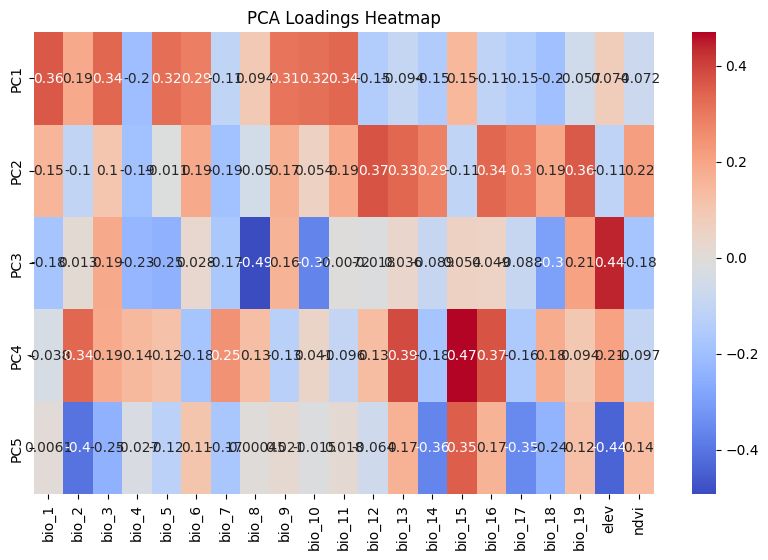

In [129]:
from sklearn.decomposition import PCA
import seaborn as sns

pca = PCA(n_components=5) 
pca_result = pca.fit_transform(combined_filtered) 
loadings = pca.components_
print("Explained Variance Ratio:", pca.explained_variance_ratio_)
print("Total explained variance:", pca.explained_variance_ratio_.sum())
loadings_df = pd.DataFrame(loadings, columns=combined_scaled.columns, index=[f'PC{i+1}' for i in range(loadings.shape[0])])
plt.figure(figsize=(10, 6))
sns.heatmap(loadings_df, annot=True, cmap='coolwarm')
plt.title('PCA Loadings Heatmap')

In [161]:
combined_filtered['PC1'] = pca_result[:,0]
combined_filtered['PC2'] = pca_result[:,1]
# combined['PC3'] = pca_result[:,2]
# combined['PC4'] = pca_result[:,3]

In [162]:
osmia_pca = pca.transform(osmia_scaled)
osmia_scaled['PC1'] = osmia_pca[:,0]
osmia_scaled['PC2'] = osmia_pca[:,1]

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- PC1
- PC2
- group


In [163]:
combined_filtered['group'] = combined_clipped['group']
osmia_scaled['group'] = 'osmia'

In [164]:
combined_filtered

,bio_1,bio_2,bio_3,bio_4,bio_5,bio_6,bio_7,bio_8,bio_9,bio_10,...,bio_15,bio_16,bio_17,bio_18,bio_19,elev,ndvi,group,PC1,PC2
0,1.819330,0.281187,0.972555,-0.880171,1.650222,1.372230,-0.442007,-0.415578,2.064730,1.689847,...,2.472665,1.473382,-1.685051,-2.262989,2.261456,-0.238621,0.418176,europe,4.714030,2.569524
1,0.731749,0.475505,1.119088,-0.849224,0.764335,0.790664,-0.358120,-1.047418,1.559207,0.382938,...,1.926387,1.011142,-1.494367,-2.114762,1.679113,1.557786,-0.983302,europe,3.288212,1.128008
2,0.758938,0.189743,0.915777,-0.857310,0.656300,0.863360,-0.489942,-1.164796,1.567361,0.416665,...,1.241277,-0.375581,-1.391691,-1.966536,0.405238,1.428586,-1.348225,europe,3.516875,-0.368196
3,1.691029,0.032574,1.474031,-1.295128,1.045226,1.505505,-0.909375,-0.228274,1.855998,1.247185,...,2.074059,-1.109728,-1.743723,-2.228783,-0.368187,-0.247471,-1.367428,europe,5.583540,-0.787377
4,1.759003,0.866999,1.723371,-0.980270,1.693436,1.323766,-0.370104,-0.050959,2.002763,1.588667,...,1.157697,-1.000965,-1.611711,-2.080556,-0.240799,-0.263400,-1.480538,europe,5.819615,-0.767006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9781,-2.786747,-0.093161,-1.694840,2.058128,-1.806897,-2.795659,1.763016,-0.595391,-2.377350,-2.062246,...,0.006210,0.358566,0.163117,0.678740,-0.195304,0.074644,-0.636518,america,-6.156229,-1.924828
9782,-2.765505,-0.364635,-1.832930,1.890375,-2.022967,-2.710848,1.559291,-0.535453,-2.467040,-2.184505,...,-0.146941,0.295122,0.339133,0.849771,-0.149808,0.005619,-3.903700,america,-6.149656,-2.357626
9783,-2.745962,-0.024578,-1.610210,1.988728,-1.742076,-2.722964,1.727065,-0.580406,-2.336583,-2.036951,...,-0.149266,0.467329,0.500481,0.849771,-0.031520,0.065794,-1.072639,america,-6.194096,-1.478137
9784,-2.756158,-0.424645,-1.734422,1.632369,-2.303858,-2.601804,1.295647,-0.630354,-2.392027,-2.344707,...,-0.408589,0.349503,0.691165,0.918183,0.068571,0.005619,-3.853246,america,-6.333093,-1.709678


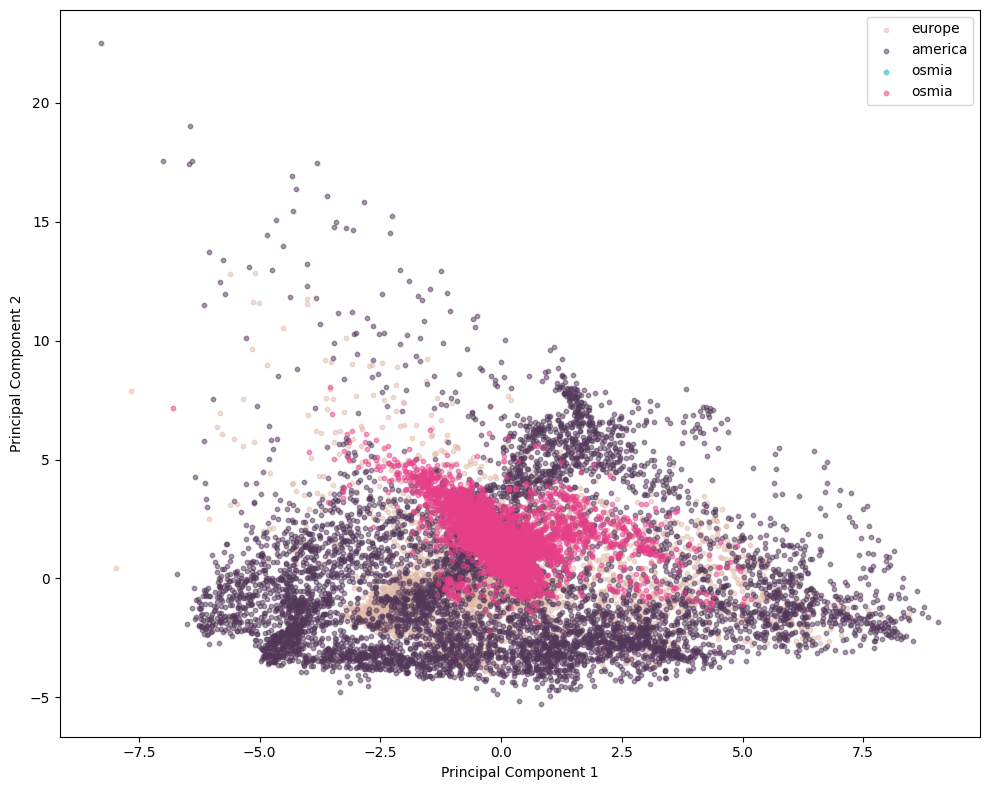

In [165]:
colors = ['#E1BAAA', '#523759', '#00B6BE','#E73F88']

plt.figure(figsize=(10, 8))

unique_labels = combined['group'].unique()  
for i, label in enumerate(unique_labels):
    subset = combined_filtered[combined_filtered['group'] == label]  
    plt.scatter(subset['PC1'], subset['PC2'], c=colors[i], label=label, s=10, marker= 'o', alpha=0.5)
plt.scatter(osmia_scaled['PC1'], osmia_scaled['PC2'], c=colors[i+1], label=label, s=10, marker= 'o', alpha=0.5)
plt.legend()
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.tight_layout()